**DSCD 611 Final Project:**

## Few Events, Many Lives: Exploratory Data Analysis of Global Disaster Impacts

| **Dataset** | EM-DAT International Disaster Database |
|---|---|
| **Source** | [Public EM-DAT](https://public.emdat.be/) (requires login) |
| **Unit of Analysis** | Individual disaster event records |
| **Time Period** | 2000–2025 |



### Research Questions

This analysis investigates the following questions:

1. How has the frequency of natural disasters changed over time?
2. Which disaster types occur most frequently worldwide?
3. Which disaster types cause the greatest total deaths?
4. Which disaster types affect the largest populations?
5. How does disaster impact vary by geographic region?
6. Are disaster impacts concentrated in a small number of catastrophic events?
7. How have disaster impacts (deaths, affected) changed over time?

### Key Findings Preview

- **Floods** are the most frequent disaster type, but **earthquakes** cause the most deaths
- **Asia** bears the highest burden of disaster impacts globally
- A small number of catastrophic events account for nearly **50%** of all recorded deaths

## Setup & Data Loading

### About the EM-DAT Database

The **Emergency Events Database (EM-DAT)** is maintained by the Centre for Research on the Epidemiology of Disasters (CRED) at the Université catholique de Louvain, Belgium. The dataset contains records of over 22,000 mass disasters worldwide from 1900 to present. Our analysis however focuses on events from 2000 onwards, comprising over 16,000 disaster records.

**Inclusion criteria** ([EM-DAT methodology](https://doc.emdat.be/docs/)) — at least one must be met:
- At least ten deaths (including dead and missing).
- At least 100 affected (people affected, injured, or homeless).
- A call for international assistance or an emergency declaration.

### Data Processing Steps

1. Load the Excel export from EM-DAT
2. Coerce key columns to numeric types (deaths, affected, damages)
3. Handle sentinels — EM-DAT uses -99 for missing coordinates
4. Construct dates from separate year/month/day columns

**Note on Missingness**:

Economic fields (damage costs, reconstruction costs) are structurally underreported. We focus analysis on consistently available fields: disaster type, geography, deaths, and affected populations.

In [6]:
# imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure pandas display options for better readability
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:,.0f}'.format)

# Configure matplotlib for cleaner plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Path to the EM-DAT dataset file
DATASET_PATH = "public_emdat_custom_request_2026-01-30_3cd9696b-0b00-4d47-875e-ba58371a5747.xlsx"

In [7]:
# helper functions

def load_data(path: str) -> pd.DataFrame:
    """
    Load EM-DAT Excel export into a pandas DataFrame.
    
    Args:
        path: Path to the .xlsx file.
        
    Returns:
        Raw disaster event data.
    """
    return pd.read_excel(path)


def coerce_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Convert specified columns to numeric, coercing errors to NaN.
    
    This safely handles cases where numeric fields might contain text annotations (a pattern sometimes seen in database exports).
    
    Args:
        df: Input dataframe.
        cols: Column names to convert.

    Returns:
        DataFrame with converted columns.
    """
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df


def fix_sentinels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Replace suspected sentinel values with NaN.
    
    Some database exports use placeholder values for missing data.
    This function treats the following as potential sentinels:
    - Longitude/Latitude: Values <= -90 (outside valid coordinate range)
    - Magnitude: Negative values
    
    Args:
        df: Input dataframe.
        
    Returns:
        DataFrame with suspected sentinels replaced by NaN.
    """
    sentinel_replacements = {
        "Longitude": lambda x: x <= -90,
        "Latitude": lambda x: x <= -90,
        "Magnitude": lambda x: x < 0
    }
    
    for column, condition in sentinel_replacements.items():
        if column in df.columns:
            df.loc[condition(df[column]), column] = np.nan
    
    return df

**Load and preprocess data**

In [8]:
# Load raw data
df = load_data(DATASET_PATH)
print("Loaded", len(df), "disaster event records")

# Define columns that should be numeric
NUMERIC_COLUMNS = [
    # Human impact
    "Total Deaths",
    "No. Injured",
    "No. Affected",
    "No. Homeless",
    "Total Affected",
    # Economic impact (in thousands of USD)
    "Total Damage ('000 US$)",
    "Total Damage, Adjusted ('000 US$)",
    "Insured Damage ('000 US$)",
    "Insured Damage, Adjusted ('000 US$)",
    "Reconstruction Costs ('000 US$)",
    "Reconstruction Costs, Adjusted ('000 US$)",
    # Event characteristics
    "Magnitude",
]

# Apply data cleaning
df = coerce_numeric(df, NUMERIC_COLUMNS)
df = fix_sentinels(df)

# Create start date from separate year/month/day columns
df["Start Month"] = pd.to_numeric(df.get("Start Month"), errors="coerce")
df["Start Day"] = pd.to_numeric(df.get("Start Day"), errors="coerce")
df["Start Year"] = pd.to_numeric(df.get("Start Year"), errors="coerce")

# Fill missing month/day with 1 (default to first of month/year)
start_month = df["Start Month"].fillna(1).astype(int)
start_day = df["Start Day"].fillna(1).astype(int)

df["Start Date"] = pd.to_datetime(
    {
        "year": df["Start Year"].astype("Int64"),
        "month": start_month,
        "day": start_day,
    },
    errors="coerce",
)

print("Preprocessing complete")

Loaded 16657 disaster event records
Preprocessing complete


**Dataset Overview**

In [9]:
print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Time range: {int(df['Start Year'].min())} to {int(df['Start Year'].max())}")
print(f"Countries: {df['Country'].nunique():,}")
print(f"Regions: {df['Region'].nunique()}")
print(f"Disaster types: {df['Disaster Type'].nunique()}")
print("=" * 60)

# Display sample records. Show first few rows
print("\nSample records:")
display_cols = ["DisNo.", "Start Year", "Country", "Disaster Type", "Total Deaths", "Total Affected"]
df[display_cols].head(10)

DATASET SUMMARY
Shape: 16,657 rows × 48 columns
Time range: 2000 to 2025
Countries: 223
Regions: 5
Disaster types: 31

Sample records:


,DisNo.,Start Year,Country,Disaster Type,Total Deaths,Total Affected
0,2018-0040-BRA,2018,Brazil,Flood,4,250
1,2002-0351-USA,2002,United States of America,Wildfire,NaN,"1,572"
2,2022-0770-RWA,2022,Rwanda,Flood,3,NaN
3,2024-9796-USA,2024,United States of America,Drought,NaN,NaN
4,2022-0563-IDN,2022,Indonesia,Road,10,20
5,2000-0620-NGA,2000,Nigeria,Flood,NaN,500
6,2022-0586-TUN,2022,Tunisia,Water,20,NaN
7,2023-0193-COD,2023,Democratic Republic of the Congo,Mass movement (wet),19,NaN
8,2022-0625-KHM,2022,Cambodia,Water,21,NaN
9,2000-0001-AGO,2000,Angola,Road,14,11


### Data Quality Assessment

Before diving into analysis, we assess data completeness. Understanding what data is missing, and *why* is critical for interpreting results.

#### Expected Patterns

- **Economic data** (damage costs, reconstruction) is often missing because:
  - Many disasters occur in regions without systematic damage assessment
  - Reporting standards vary significantly by country
  
- **Geographic coordinates** may be missing for events affecting large areas

- **Human impact metrics** (deaths, affected) are generally well-reported due to EM-DAT's inclusion criteria

### Missingness Analysis

In [10]:
# Calculate missing percentage for all columns
missing_pct = (df.isna().mean() * 100).round(2)
missing_top10 = missing_pct.sort_values(ascending=False).head(10)

print("TOP 10 COLUMNS BY MISSING RATE")
print("=" * 50)
for col, pct in missing_top10.items():
    bar = "█" * int(pct // 5) + "░" * (20 - int(pct // 5))
    print(f"{col[:40]:<40} {bar} {pct:>5.1f}%")

# Key fields we'll use in analysis
print("\n" + "=" * 50)
print("KEY ANALYSIS FIELDS - COMPLETENESS")
print("=" * 50)
key_fields = ["Disaster Type", "Country", "Region", "Start Year", "Total Deaths", "Total Affected"]
for field in key_fields:
    if field in df.columns:
        complete_pct = 100 - missing_pct[field]
        print(f"{field:<25} {complete_pct:>6.1f}% complete")

TOP 10 COLUMNS BY MISSING RATE
Reconstruction Costs ('000 US$)          ███████████████████░  99.8%
Reconstruction Costs, Adjusted ('000 US$ ███████████████████░  99.8%
AID Contribution ('000 US$)              ███████████████████░  97.1%
Insured Damage, Adjusted ('000 US$)      ███████████████████░  95.7%
Insured Damage ('000 US$)                ███████████████████░  95.7%
River Basin                              ██████████████████░░  92.0%
No. Homeless                             ██████████████████░░  91.9%
Longitude                                █████████████████░░░  89.5%
Latitude                                 █████████████████░░░  88.9%
Total Damage, Adjusted ('000 US$)        ████████████████░░░░  80.6%

KEY ANALYSIS FIELDS - COMPLETENESS
Disaster Type              100.0% complete
Country                    100.0% complete
Region                     100.0% complete
Start Year                 100.0% complete
Total Deaths                80.5% complete
Total Affected              

### Analysis: Temporal Trends (Research Question 1)

#### Question: How has the frequency of natural disasters changed over time?

**Why this matters**: Understanding temporal trends helps distinguish between:
- Actual increases in disaster frequency (possibly climate-related)
- Improvements in disaster reporting and database coverage
- Changes in EM-DAT inclusion criteria over time

**Interpretation note**: An upward trend in recorded events doesn't necessarily mean more disasters are occurring. It may reflect better global reporting infrastructure.

Events per year - summary statistics
Mean events/year:   641
Median events/year: 604
Max events/year:    867 (2000)
Min events/year:    497 (2018)

Top 10 years by event count
------------------------------
2000: 867 events
2005: 853 events
2002: 847 events
2006: 758 events
2004: 752 events
2001: 752 events
2007: 723 events
2003: 719 events
2010: 668 events
2008: 649 events


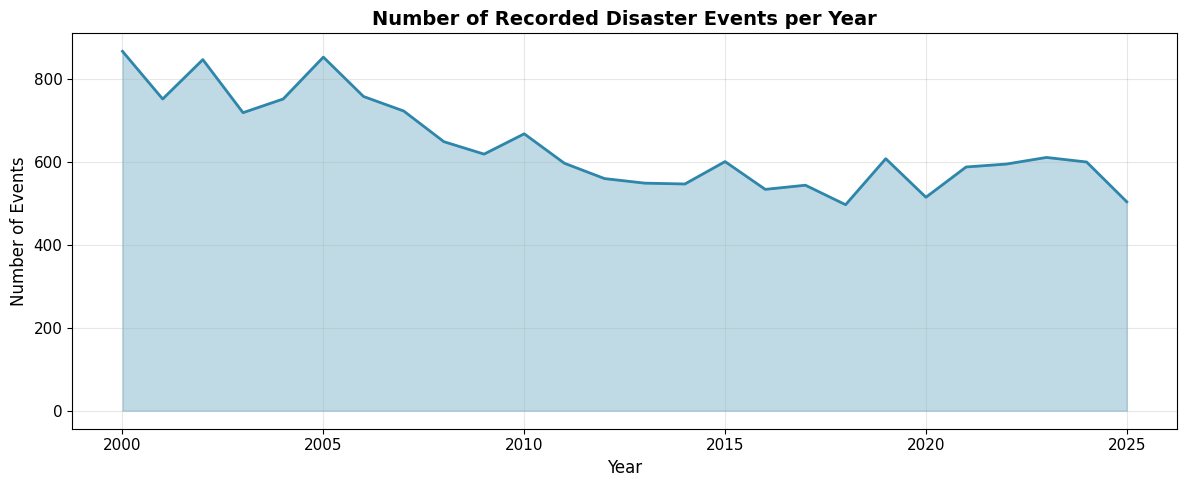

In [11]:
# Count events by year
events_by_year = df.groupby("Start Year").size().sort_index()

# Summary statistics
print("Events per year - summary statistics")
print("=" * 50)
print(f"Mean events/year:   {events_by_year.mean():,.0f}")
print(f"Median events/year: {events_by_year.median():,.0f}")
print(f"Max events/year:    {events_by_year.max():,.0f} ({int(events_by_year.idxmax())})")
print(f"Min events/year:    {events_by_year.min():,.0f} ({int(events_by_year.idxmin())})")

print("\nTop 10 years by event count")
print("-" * 30)
for year, count in events_by_year.sort_values(ascending=False).head(10).items():
    print(f"{int(year)}: {count:,} events")

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(events_by_year.index, events_by_year.values, linewidth=2, color='#2E86AB')
plt.fill_between(events_by_year.index, events_by_year.values, alpha=0.3, color='#2E86AB')
plt.title("Number of Recorded Disaster Events per Year", fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Insight

The chart reveals that recorded disaster events peaked in the early 2000s and have shown some decline in recent years. This pattern likely reflects a combination of:
- Improved global monitoring since the 1990s
- Database completeness catching up with historical events
- Possible consolidation of how events are classified

### Analysis: Disaster Type Frequency (Research Question 2)

### Question: Which disaster types occur most frequently worldwide?

**Why this matters**: Understanding which hazards occur most often helps prioritize:
- Early warning system investments
- Preparedness training focus areas
- Research funding allocation

**Note**: Frequency ≠ Impact. The most common disasters may not be the deadliest.

Disaster types by frequency
Disaster Type                       Count   % of Total
------------------------------------------------------------
Flood                               4,232        25.4%
Storm                               2,815        16.9%
Road                                2,238        13.4%
Water                               1,174         7.0%
Epidemic                              888         5.3%
Earthquake                            693         4.2%
Extreme temperature                   568         3.4%
Mass movement (wet)                   494         3.0%
Explosion (Industrial)                470         2.8%
Fire (Miscellaneous)                  452         2.7%
Air                                   445         2.7%
Drought                               420         2.5%
Wildfire                              336         2.0%
Rail                                  253         1.5%
Miscellaneous accident (General)        199         1.2%


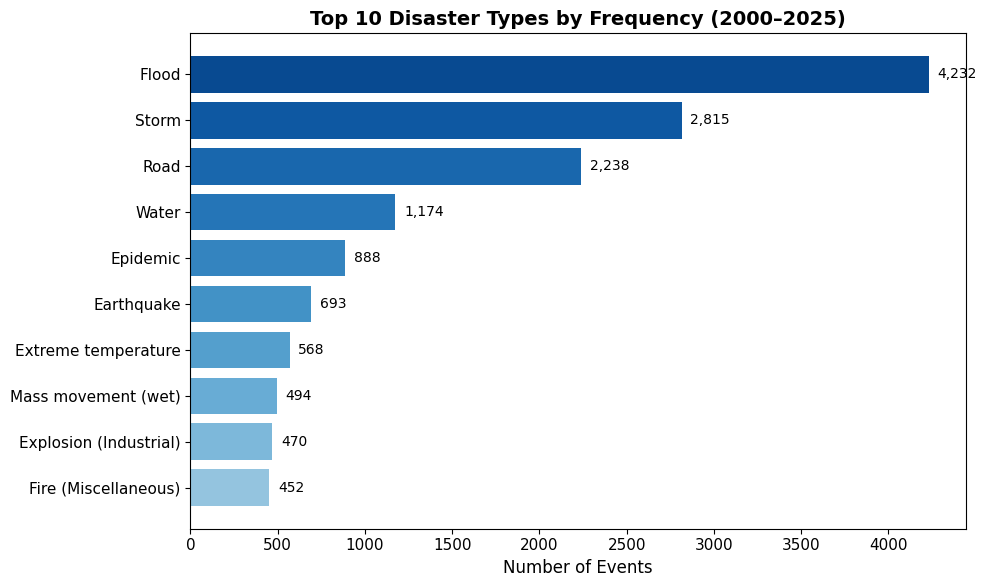

In [12]:
# Count by disaster type
type_counts = df["Disaster Type"].value_counts()
total_events = len(df)

print("Disaster types by frequency")
print("=" * 60)
print(f"{'Disaster Type':<30} {'Count':>10} {'% of Total':>12}")
print("-" * 60)
for dtype, count in type_counts.head(15).items():
    pct = count / total_events * 100
    print(f"{dtype:<30} {count:>10,} {pct:>11.1f}%")

# Visualization - Top 10
top_types = type_counts.head(10)[::-1]  # Reverse for horizontal bar chart

plt.figure(figsize=(10, 6))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_types)))
plt.barh(top_types.index, top_types.values, color=colors)
plt.title("Top 10 Disaster Types by Frequency (2000–2025)", fontweight='bold')
plt.xlabel("Number of Events")

# Add value labels
for i, (dtype, count) in enumerate(top_types.items()):
    plt.text(count + 50, i, f"{count:,}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

#### Insight

**Floods** dominate disaster frequency globally, followed by **storms** and **transport accidents** (road, water, air). This reflects:
- The widespread nature of hydrological hazards across all continents
- Higher frequency but often lower per-event mortality for floods vs. earthquakes
- The inclusion of technological disasters in the EM-DAT database

### Analysis: Mortality by Disaster Type (Research Question 3)

#### Question: Which disaster types cause the greatest total deaths?

**Why this matters**: While frequency matters for preparedness, mortality data reveals which hazards pose the greatest threat to human life—a key input for life-saving interventions.

**Methodology**: We sum all reported deaths across events of each type. This means a single catastrophic event can significantly influence a disaster type's ranking.

Total deaths by disaster type
Disaster Type                           Deaths   % of Total
------------------------------------------------------------
Earthquake                             796,225        42.4%
Extreme temperature                    352,756        18.8%
Storm                                  226,658        12.1%
Flood                                  140,570         7.5%
Epidemic                               125,046         6.7%
Water                                   52,811         2.8%
Road                                    48,292         2.6%
Drought                                 24,197         1.3%
Mass movement (wet)                     22,804         1.2%
Air                                     17,653         0.9%
Explosion (Industrial)                  14,362         0.8%
Fire (Miscellaneous)                    11,267         0.6%
Miscellaneous accident (General)           9,557         0.5%
Rail                                     7,144         0.4%
Explosi

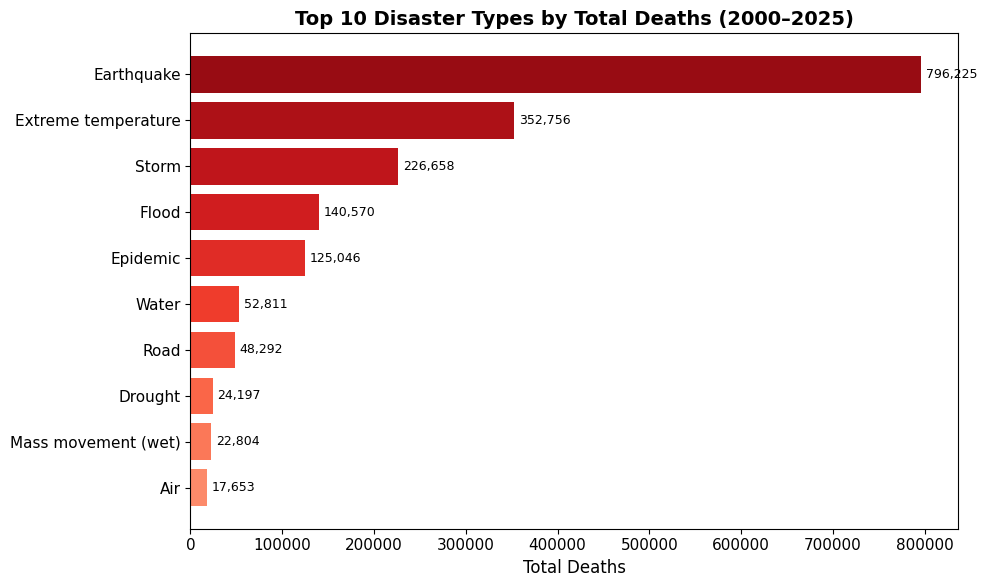

In [13]:
# Sum deaths by type, using min_count=1 to return NaN if all values are NaN
deaths_by_type = (
    df.groupby("Disaster Type", as_index=False)["Total Deaths"]
    .sum(min_count=1)
    .sort_values("Total Deaths", ascending=False)
)

total_deaths_all = deaths_by_type["Total Deaths"].sum()

print("Total deaths by disaster type")
print("=" * 60)
print(f"{'Disaster Type':<30} {'Deaths':>15} {'% of Total':>12}")
print("-" * 60)
for _, row in deaths_by_type.head(15).iterrows():
    pct = row["Total Deaths"] / total_deaths_all * 100 if total_deaths_all else 0
    print(f"{row['Disaster Type']:<30} {row['Total Deaths']:>15,.0f} {pct:>11.1f}%")

# Visualization
top_deaths = deaths_by_type.head(10).iloc[::-1]  # Reverse for barh

plt.figure(figsize=(10, 6))
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_deaths)))
plt.barh(top_deaths["Disaster Type"], top_deaths["Total Deaths"], color=colors)
plt.title("Top 10 Disaster Types by Total Deaths (2000–2025)", fontweight='bold')
plt.xlabel("Total Deaths")

# Add value labels
for i, (_, row) in enumerate(top_deaths.iterrows()):
    plt.text(row["Total Deaths"] + 5000, i, f"{row['Total Deaths']:,.0f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

#### Insight

**Earthquakes** are the deadliest disaster type by total mortality, despite being less frequent than floods. This is due to:
- Sudden onset with no warning time
- Potential for building collapse in densely populated areas
- Several catastrophic events (Haiti 2010, Indian Ocean 2004, Turkey 2023)

**Extreme temperatures** (heat waves, cold waves) rank second—often underestimated as a disaster type but causing significant excess mortality.

### Analysis: Population Impact (Research Question 4)

#### Question: Which disaster types affect the largest populations?

**Why this matters**: "Total Affected" captures people who were injured, made homeless, or required immediate assistance, even if they survived. This metric is crucial for:
- Humanitarian response planning
- Resource pre-positioning
- Recovery program design


Total affected by disaster type
Disaster Type                              Affected   % of Total
-----------------------------------------------------------------
Flood                                 1,876,569,264        38.6%
Drought                               1,711,448,907        35.2%
Storm                                   923,780,791        19.0%
Earthquake                              159,293,444         3.3%
Extreme temperature                     133,910,173         2.8%
Wildfire                                 15,158,160         0.3%
Epidemic                                 12,726,705         0.3%
Mass movement (wet)                       8,832,438         0.2%
Volcanic activity                         6,636,630         0.1%
Infestation                               3,200,000         0.1%
Fire (Miscellaneous)                        672,332         0.0%
Poisoning                                   585,420         0.0%
Oil spill                                   529,137     

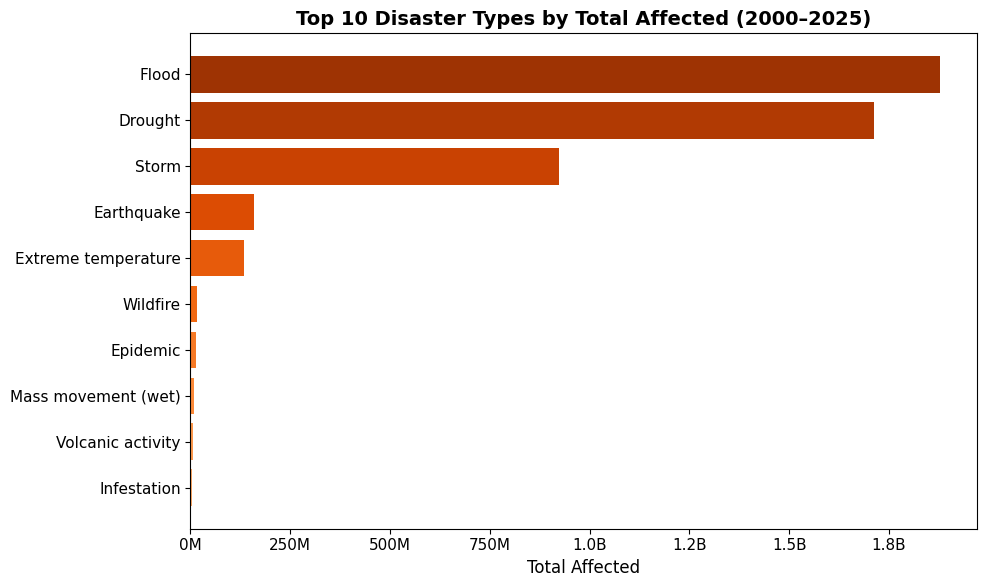

In [14]:
"""Analyze and visualize people affected by disaster type."""

# Aggregate total affected by disaster type
affected_by_type = (
    df.groupby("Disaster Type", as_index=False)["Total Affected"]
    .sum(min_count=1)
    .sort_values("Total Affected", ascending=False)
)

total_affected_all = affected_by_type["Total Affected"].sum()

# Display summary table
print("\nTotal affected by disaster type")
print("=" * 65)
print(f"{'Disaster Type':<30} {'Affected':>20} {'% of Total':>12}")
print("-" * 65)

for _, row in affected_by_type.head(15).iterrows():
    pct = (
        row["Total Affected"] / total_affected_all * 100
        if total_affected_all
        else 0
    )
    print(
        f"{row['Disaster Type']:<30} "
        f"{row['Total Affected']:>20,.0f} "
        f"{pct:>11.1f}%"
    )

# Prepare data for visualization (reverse for bottom-to-top display)
top_affected = affected_by_type.head(10).iloc[::-1]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(top_affected)))
plt.barh(top_affected["Disaster Type"], top_affected["Total Affected"], color=colors)
plt.title("Top 10 Disaster Types by Total Affected (2000–2025)", fontweight="bold")
plt.xlabel("Total Affected")

# Format x-axis labels as billions/millions
ax = plt.gca()
ax.xaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, p: f"{x/1e9:.1f}B" if x >= 1e9 else f"{x/1e6:.0f}M"
    )
)

plt.tight_layout()
plt.show()

### Insight

**Floods** and **droughts** affect the largest populations—both measuring in the billions of affected people over the study period. This contrast with mortality data shows:

| Disaster Type | Deaths | Affected | Implication |
|---------------|--------|----------|-------------|
| Earthquake | Very High | Moderate | Life-saving focus needed |
| Flood | Moderate | Very High | Humanitarian/recovery focus |
| Drought | Low | Very High | Long-term resilience focus |

### Analysis: Regional Variation (Research Question 5)

#### Question: How does disaster impact vary by region?

**Why this matters**: Geographic analysis reveals where investments in disaster risk reduction would have the greatest impact, and highlights global inequities in disaster burden.

Regional Impact Summary
Region              Events          Deaths             Affected
----------------------------------------------------------------------
Asia                 6,725         978,600        3,892,364,965
Africa               4,270         245,566          591,403,802
Americas             3,316         303,783          340,467,753
Europe               1,935         344,257           22,072,710
Oceania                411           4,624            9,061,513


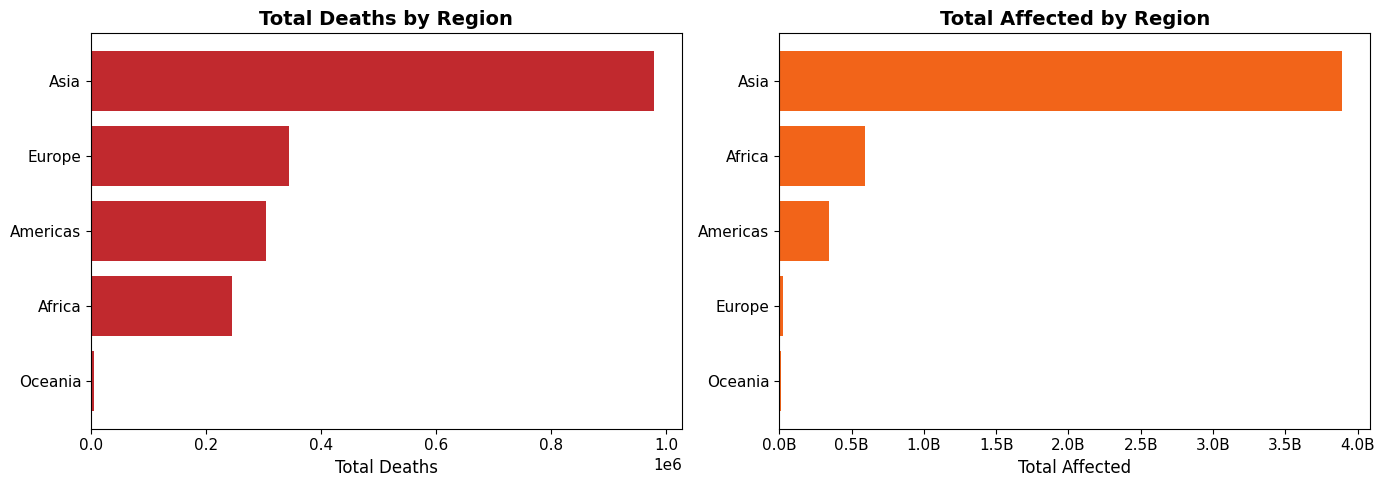

In [15]:
"""Analyze and visualize disaster impact by geographic region."""

# Aggregate deaths by region
deaths_by_region = (
    df.groupby("Region", as_index=False)["Total Deaths"]
    .sum(min_count=1)
    .sort_values("Total Deaths", ascending=False)
)

# Aggregate affected by region
affected_by_region = (
    df.groupby("Region", as_index=False)["Total Affected"]
    .sum(min_count=1)
    .sort_values("Total Affected", ascending=False)
)

# Count disaster events by region
events_by_region = (
    df.groupby("Region")
    .size()
    .reset_index(name="Events")
    .sort_values("Events", ascending=False)
)

# Display regional summary table
print("Regional Impact Summary")
print("=" * 70)
print(f"{'Region':<15} {'Events':>10} {'Deaths':>15} {'Affected':>20}")
print("-" * 70)

regional_summary = (
    events_by_region
    .merge(deaths_by_region, on="Region")
    .merge(affected_by_region, on="Region")
)

for _, row in regional_summary.iterrows():
    print(
        f"{row['Region']:<15} "
        f"{row['Events']:>10,} "
        f"{row['Total Deaths']:>15,.0f} "
        f"{row['Total Affected']:>20,.0f}"
    )

# Create side-by-side comparison charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Deaths by region
top_deaths = deaths_by_region.iloc[::-1]
axes[0].barh(top_deaths["Region"], top_deaths["Total Deaths"], color="#C1292E")
axes[0].set_title("Total Deaths by Region", fontweight="bold")
axes[0].set_xlabel("Total Deaths")

# Chart 2: Affected by region
top_affected = affected_by_region.iloc[::-1]
axes[1].barh(top_affected["Region"], top_affected["Total Affected"], color="#F26419")
axes[1].set_title("Total Affected by Region", fontweight="bold")
axes[1].set_xlabel("Total Affected")
axes[1].xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f"{x/1e9:.1f}B")
)

plt.tight_layout()
plt.show()

### Insight

**Asia** bears a disproportionate share of global disaster impacts:
- Contains ~60% of the world's population
- Exposed to multiple hazard types (monsoons, earthquakes, typhoons)
- Includes densely populated river deltas and coastal areas

This geographic concentration suggests that investments in Asian disaster resilience could have **outsized global impact**.

### Analysis: Impact Concentration (Research Question 6)

#### Question: Are disaster impacts concentrated in a small number of events?

**Why this matters**: If a small fraction of events drives most of the damage, policy focus should be on:
- Preparing for rare but catastrophic events
- Building resilience against "Black Swan" disasters
- Understanding what makes certain events so devastating

**Hypothesis**: Disaster impacts likely follow a power-law distribution, with a few mega-disasters dominating total mortality.


 Concentration of disaster mortality
Total events with reported deaths: 13,414
Total deaths recorded: 1,876,830

Top 10 events account for 46.8% of all deaths

Rank  Year   Country                   Type                       Deaths
----------------------------------------------------------------------
1     2010   Haiti                     Earthquake                222,570
2     2004   Indonesia                 Earthquake                165,708
3     2008   Myanmar                   Storm                     138,366
4     2008   China                     Earthquake                 87,476
5     2005   Pakistan                  Earthquake                 73,338
6     2010   Russian Federation        Extreme temperature        55,736
7     2023   Türkiye                   Earthquake                 53,000
8     2004   Sri Lanka                 Earthquake                 35,399
9     2003   Iran (Islamic Republic o  Earthquake                 26,796
10    2003   Italy                    

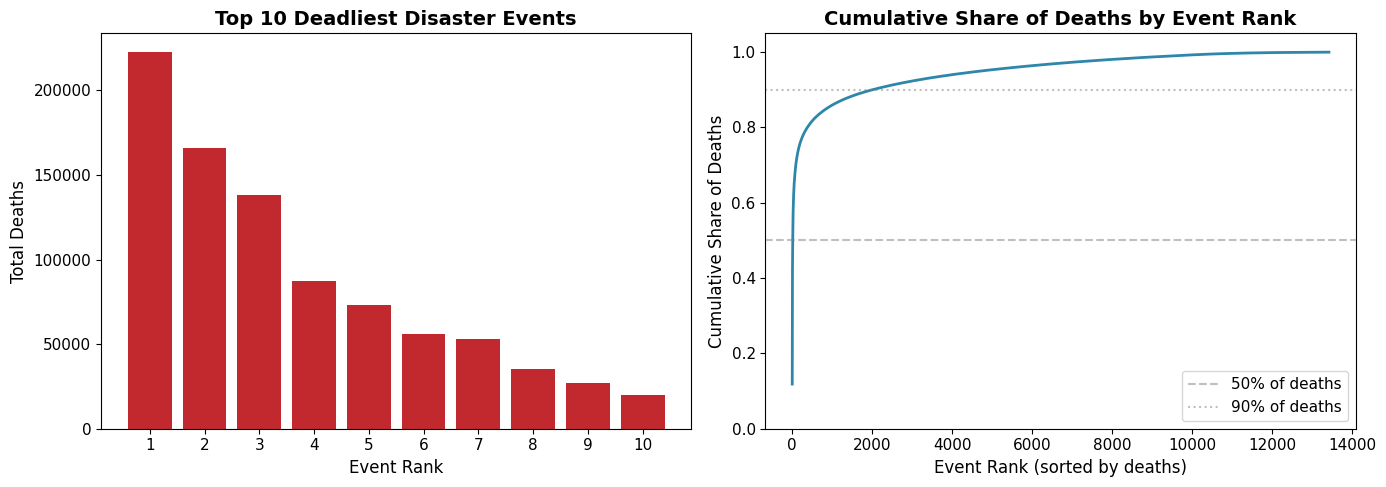


 Concentration Metrics
• Top 14 events (0.1%) account for 50% of deaths
• Top 1,999 events (14.9%) account for 90% of deaths


In [16]:
# Extract events with reported deaths
deaths_df = df[["DisNo.", "Country", "Disaster Type", "Start Year", "Total Deaths"]].dropna(subset=["Total Deaths"])
deaths_df = deaths_df.sort_values("Total Deaths", ascending=False).reset_index(drop=True)

if len(deaths_df) > 0:
    total_deaths = deaths_df["Total Deaths"].sum()
    
    # Top 10 deadliest events
    top10 = deaths_df.head(10)
    share_top10 = top10["Total Deaths"].sum() / total_deaths
    
    print("\n Concentration of disaster mortality")
    print("=" * 70)
    print(f"Total events with reported deaths: {len(deaths_df):,}")
    print(f"Total deaths recorded: {total_deaths:,.0f}")
    print(f"\nTop 10 events account for {share_top10:.1%} of all deaths")
    print("=" * 70)
    
    print(f"\n{'Rank':<5} {'Year':<6} {'Country':<25} {'Type':<20} {'Deaths':>12}")
    print("-" * 70)
    for i, (_, row) in enumerate(top10.iterrows(), 1):
        print(f"{i:<5} {int(row['Start Year']):<6} {row['Country'][:24]:<25} {row['Disaster Type'][:19]:<20} {row['Total Deaths']:>12,.0f}")
    
    # Visualization: Top 10 events bar chart
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart of top 10
    axes[0].bar(range(1, 11), top10["Total Deaths"].values, color='#C1292E')
    axes[0].set_title("Top 10 Deadliest Disaster Events", fontweight='bold')
    axes[0].set_xlabel("Event Rank")
    axes[0].set_ylabel("Total Deaths")
    axes[0].set_xticks(range(1, 11))
    
    # Cumulative share curve (Lorenz-like)
    deaths_df["cum_share"] = deaths_df["Total Deaths"].cumsum() / total_deaths
    ranks = np.arange(1, len(deaths_df) + 1)
    
    axes[1].plot(ranks, deaths_df["cum_share"], linewidth=2, color='#2E86AB')
    axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% of deaths')
    axes[1].axhline(y=0.9, color='gray', linestyle=':', alpha=0.5, label='90% of deaths')
    axes[1].set_title("Cumulative Share of Deaths by Event Rank", fontweight='bold')
    axes[1].set_xlabel("Event Rank (sorted by deaths)")
    axes[1].set_ylabel("Cumulative Share of Deaths")
    axes[1].legend()
    axes[1].set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.show()
    
    # Find how many events account for 50% and 90% of deaths
    pct_50 = (deaths_df["cum_share"] >= 0.5).idxmax() + 1
    pct_90 = (deaths_df["cum_share"] >= 0.9).idxmax() + 1
    
    print(f"\n Concentration Metrics")
    print(f"• Top {pct_50:,} events ({pct_50/len(deaths_df)*100:.1f}%) account for 50% of deaths")
    print(f"• Top {pct_90:,} events ({pct_90/len(deaths_df)*100:.1f}%) account for 90% of deaths")
else:
    print("No death data available for concentration analysis.")

### Insight

The concentration analysis confirms a **highly skewed distribution**:
- **Top 10 events** (out of thousands) account for nearly **half** of all recorded deaths
- Most disasters cause relatively few fatalities; a handful cause catastrophic loss of life

**Implication**: Disaster policy should include focus on "tail risk" events—rare but devastating disasters that require special preparedness measures (early warning systems, building codes, evacuation planning).

### Analysis: Impact Trends Over Time (Research Question 7)

#### Question: How have disaster impacts changed over time?

**Why this matters**: Even if disaster *frequency* is stable, are we getting better at reducing their *impacts*? This analysis examines whether deaths and affected populations are trending up or down.

Annual Impact Trends

 Top 10 years by total deaths
------------------------------
2010:         336,900 deaths
2004:         255,034 deaths
2008:         248,923 deaths
2023:         143,190 deaths
2003:         123,856 deaths
2005:         105,158 deaths
2024:          88,798 deaths
2022:          84,368 deaths
2001:          47,961 deaths
2011:          40,774 deaths


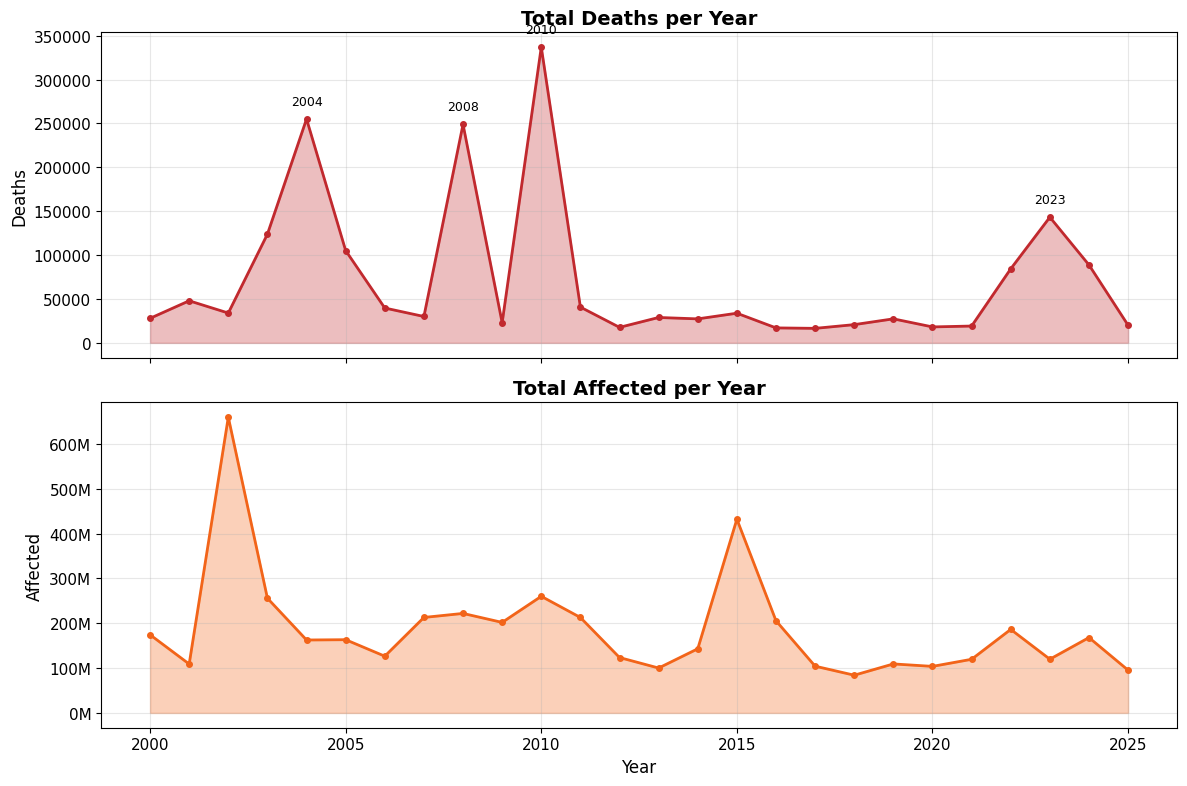

In [ ]:
# Aggregate deaths and affected population by year
deaths_by_year = (
    df.groupby("Start Year")["Total Deaths"].sum(min_count=1).sort_index()
)
affected_by_year = (
    df.groupby("Start Year")["Total Affected"].sum(min_count=1).sort_index()
)

# Display deadliest years
print("Annual Impact Trends")
print("=" * 50)
print("\n Top 10 years by total deaths")
print("-" * 30)

for year, deaths in deaths_by_year.sort_values(ascending=False).head(10).items():
    print(f"{int(year)}: {deaths:>15,.0f} deaths")

# Create stacked time series charts
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Chart 1: Annual deaths over time
axes[0].plot(
    deaths_by_year.index,
    deaths_by_year.values,
    linewidth=2,
    color="#C1292E",
    marker="o",
    markersize=4,
)
axes[0].fill_between(
    deaths_by_year.index, deaths_by_year.values, alpha=0.3, color="#C1292E"
)
axes[0].set_title("Total Deaths per Year", fontweight="bold")
axes[0].set_ylabel("Deaths")
axes[0].grid(True, alpha=0.3)

# Annotate major disaster years
MAJOR_DISASTER_YEARS = [
    2004,  # Indian Ocean tsunami
    2008,  # Cyclone Nargis
    2010,  # Haiti earthquake
    2023,  # Turkey-Syria earthquake
]

for year in MAJOR_DISASTER_YEARS:
    if year in deaths_by_year.index:
        axes[0].annotate(
            str(int(year)),
            (year, deaths_by_year[year]),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
            fontsize=9,
        )

# Chart 2: Annual affected population over time
axes[1].plot(
    affected_by_year.index,
    affected_by_year.values,
    linewidth=2,
    color="#F26419",
    marker="o",
    markersize=4,
)
axes[1].fill_between(
    affected_by_year.index, affected_by_year.values, alpha=0.3, color="#F26419"
)
axes[1].set_title("Total Affected per Year", fontweight="bold")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Affected")
axes[1].grid(True, alpha=0.3)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x/1e6:.0f}M"))

plt.tight_layout()
plt.show()

### Insight

**Deaths over time** show a spiky pattern, driven by catastrophic events:
- **2004**: Indian Ocean earthquake and tsunami
- **2008**: Cyclone Nargis (Myanmar) and Sichuan earthquake (China)
- **2010**: Haiti earthquake
- **2023**: Turkey-Syria earthquake

**Affected populations** show higher year-to-year variability, influenced by large-scale floods and droughts affecting densely populated regions.

There's no clear downward trend in either metric, suggesting that while disaster preparedness has improved, the combination of population growth and climate change continues to drive high impact levels.

### Conclusions

#### Summary of Findings

| Question | Key Finding |
|----------|-------------|
| **Q1: Temporal trends** | Event recording peaked in early 2000s; recent slight decline |
| **Q2: Frequency by type** | Floods most common, followed by storms and transport accidents |
| **Q3: Mortality by type** | Earthquakes cause most deaths; extreme temperatures rank second |
| **Q4: Affected by type** | Floods and droughts affect the most people (billions) |
| **Q5: Regional patterns** | Asia bears the highest burden in both deaths and affected |
| **Q6: Concentration** | ~50% of deaths from top 10 events; highly skewed distribution |
| **Q7: Impact trends** | No clear downward trend; catastrophic events drive annual spikes |

#### Policy Implications

1. **Prioritize earthquake preparedness** — despite being less frequent, earthquakes cause the most deaths
2. **Invest in Asian resilience** — the region bears disproportionate global disaster burden
3. **Plan for tail risks** — a small number of catastrophic events dominate mortality statistics
4. **Don't neglect slow-onset disasters** — droughts affect massive populations with long-term impacts

#### Next Steps

For interactive exploration of this data, run the companion dashboard:

```bash
streamlit run dashboard.py
```